In [4]:
import numpy as np
import pickle
from pathlib import Path
import time
import torch
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
%matplotlib inline 
from torchsummary import summary
from torcheval import metrics
import torch.nn as nn


In [5]:
## select series with real wildfire
# %pip install torchsummary torcheval livelossplot

In [6]:
if torch.cuda.is_available(): 
 dev = "cuda" 
else: 
 dev = "cpu" 
device = torch.device(dev) 


In [7]:
data_path =  'data/Ferguson_fire_train.npy'
train_data = np.load(data_path).reshape(125,100,256,256)
test_path =  'data/Ferguson_fire_test.npy'
test_data = np.load(test_path).reshape(50,100,256,256)

# count1 =0
# idx = []
# for i in range(len(train_data)):
#     if train_data[i].sum()/99>3000:
#         count1+=1
#         idx.append(i)
# train_data = train_data[idx]
# print("Number of significant wildfires in train data: ",count1)
# count2 =0
# idx = []
# for i in range(len(test_data)):
#     if test_data[i].sum()/99>3000:
#         count2+=1
#         idx.append(i)
# test_data = test_data[idx]
# print("Number of significant wildfires in test data: ",count2)


In [8]:
split_size = 1
train_4d=train_data.reshape(-1,256,256)[:-10,:,:]
train_shift_4d=train_data.reshape(-1,256,256)[10:,:,:]
test_4d = test_data.reshape(-1,256,256)[:-10,:,:]
test_shift_4d= test_data.reshape(-1,256,256)[10:,:,:]

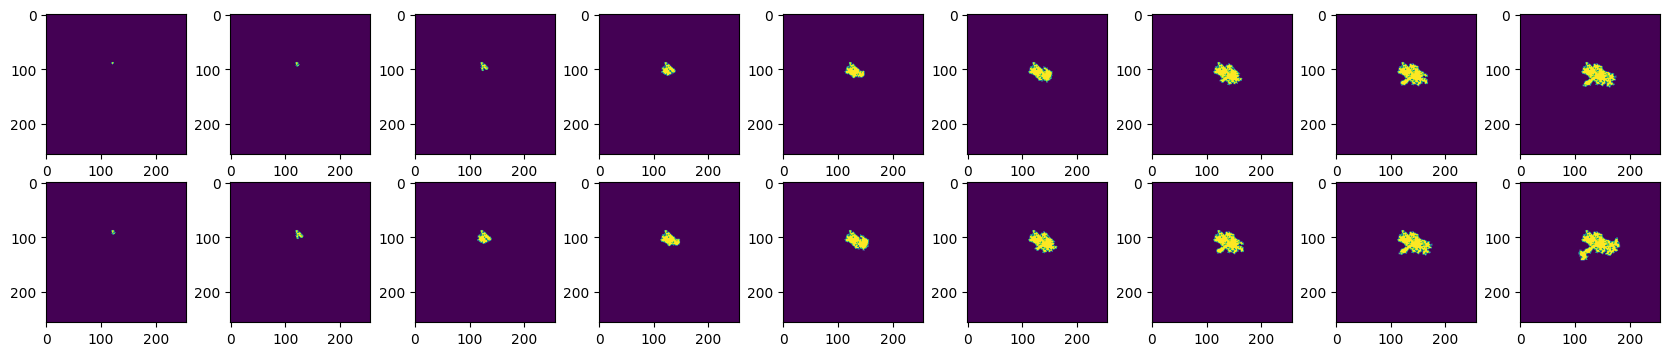

In [9]:
fig, axs = plt.subplots(2,9, figsize=(21,4))

for i in range(9):
    axs[0,i].imshow(train_4d[1000+i*10])
    axs[1,i].imshow(train_shift_4d[1000+i*10])

In [10]:
assert (train_shift_4d[0][1].all() ==train_4d[0][2].all())
assert (test_shift_4d[0][1].all() == test_4d[0][2].all())

In [11]:
del train_data, test_data

In [12]:
#########################
indices1 = torch.randperm(len(train_4d)//5)
indices2 = torch.randperm(len(test_4d)//5)

In [13]:
train_subset = torch.utils.data.Subset(torch.tensor(train_4d,dtype=torch.float32),indices1)
train_shift_subset = torch.utils.data.Subset(torch.tensor(train_shift_4d,dtype=torch.float32),indices1)

test_subset = torch.utils.data.Subset(torch.tensor(test_4d,dtype=torch.float32),indices2)
test_shift_subset = torch.utils.data.Subset(torch.tensor(test_shift_4d,dtype=torch.float32),indices2)


In [14]:
test_shift_subset.dataset.shape

torch.Size([4990, 256, 256])

In [15]:
trainloader = torch.utils.data.DataLoader(train_subset,batch_size=64, shuffle = False)
trainshiftloader = torch.utils.data.DataLoader(train_shift_subset,batch_size=64, shuffle = False)
testloader = torch.utils.data.DataLoader(test_subset,batch_size=64, shuffle = False)
testshiftloader = torch.utils.data.DataLoader(test_shift_subset,batch_size=64, shuffle = False)
del train_subset, test_subset, train_shift_subset, test_shift_subset

In [16]:
assert (trainloader.dataset[0][1].all() ==trainshiftloader.dataset[0][2].all())


### Code for Training the Model in model_training.ipynb notebook

In [17]:

class VAE(nn.Module):
    def __init__(self, latent_dim = 16,latent_pixel_size = 16, num =64):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            
            nn.Conv2d(1, 16, kernel_size=5, stride=2, padding=2),  # Example for 3D conv layer
            nn.LeakyReLU(),
            
            nn.Conv2d(16,32, kernel_size = 3, stride= 1, padding = 1),
            nn.LeakyReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride= 1, padding=1),
            nn.LeakyReLU(),

            nn.Conv2d(64,64 , kernel_size = 3, stride = 2, padding = 1),
            nn.LeakyReLU(),
            
            nn.Conv2d(64,64, kernel_size = 3, stride = 1, padding = 1),
            nn.LeakyReLU(),
            
            nn.Flatten(),
            # nn.Linear(num*latent_pixel_size*latent_pixel_size,latent_pixel_size*num),
            # nn.LeakyReLU(),
            nn.Dropout(),
            
        )
        ### Latent space transformations

        self.mu = nn.Linear(num*latent_pixel_size*latent_pixel_size,latent_dim)
        self.logvar = nn.Linear(num*latent_pixel_size*latent_pixel_size,latent_dim)
        
        
        self.decoder = nn.Sequential(
            
            # nn.Linear(latent_dim, latent_pixel_size*num),

            
            nn.Linear(latent_dim,num*latent_pixel_size*latent_pixel_size),
            nn.LeakyReLU(),
            
            nn.Unflatten(1,(num,latent_pixel_size,latent_pixel_size)),

 
            
            nn.ConvTranspose2d(64,64, kernel_size = 3, stride =1, padding = 1),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(64,64, kernel_size =4, stride = 2, padding =1),
            nn.LeakyReLU(),           
            
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride= 1, padding=1),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(32,16, kernel_size =  3, stride= 1, padding = 1),
            nn.LeakyReLU(),
            
            
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=5, stride=2, padding=2, output_padding = 1),

            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        
        return mu, logvar
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Calculate standard deviation from log variance
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mu, logvar = self.encode(x)
        
        z = self.reparameterize(mu, logvar)
        z = self.decode(z)
        return z, mu, logvar

 


#### Show layers in my model

In [18]:

channel_size = 100//split_size -1
print("Number of time steps" , channel_size)
model = VAE(latent_dim  =128,latent_pixel_size=64
             ).to(device)
summary(model, (1,256,256))

Number of time steps 99
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             416
         LeakyReLU-2         [-1, 16, 128, 128]               0
            Conv2d-3         [-1, 32, 128, 128]           4,640
         LeakyReLU-4         [-1, 32, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          18,496
         LeakyReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7           [-1, 64, 64, 64]          36,928
         LeakyReLU-8           [-1, 64, 64, 64]               0
            Conv2d-9           [-1, 64, 64, 64]          36,928
        LeakyReLU-10           [-1, 64, 64, 64]               0
          Flatten-11               [-1, 262144]               0
          Dropout-12               [-1, 262144]               0
           Linear-13                  [-1, 128]      33,554,560
           Line

In [19]:
def train(model, optimizer, criterion, dataloader,testloader, scheduler = 0):
    model.train()
    train_loss = 0
    for X, Y in zip(dataloader, testloader):
        X = X.to(device).view(-1,1,256,256)
        Y = Y.to(device).view(-1,1,256,256)
        
        optimizer.zero_grad()
        a2, mu, logvar =model(X)
        loss = criterion(Y, a2, mu, logvar)
        loss.backward()
        train_loss += loss*X.size(0)
        optimizer.step()
        if scheduler !=0:
            scheduler.step()

    return train_loss/len(dataloader.dataset)
    
def validate(model, criterion, dataloader,testloader):
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for X, Y in zip(dataloader, testloader):
            X = X.to(device).view(-1,1,256,256)
            Y = Y.to(device).view(-1,1,256,256)
            a2, mu, logvar =model(X)
            loss = criterion(Y, a2, mu, logvar)
            valid_loss += loss*X.size(0)
    return valid_loss/len(dataloader.dataset)

In [20]:
def loss_function(x, x_hat, mu, logvar):
    # Flatten the input and output for binary cross-entropy loss calculation
    x = x.view(-1, x.size(1) * x.size(2) * x.size(3) )
    x_hat = x_hat.view(-1, x_hat.size(1) * x_hat.size(2) * x_hat.size(3) )
    
    # MSE loss
    
    reproduction_loss = loss(x_hat, x)#, reduction='mean')
    
    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return reproduction_loss + KLD

In [21]:
epochs = 50

# save_path = "VAE.pth"
# try: 
#     model.load_state_dict(torch.load("VAE.pth",map_location='cpu'))
# except FileNotFoundError:

loss_func = loss_function #torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
 
loss = nn.BCELoss(reduction='mean')

liveloss = PlotLosses()
for epoch in range(epochs):
    logs = {}
    loss1 = train(model, optimizer, loss_func, trainloader, trainshiftloader)
    
    loss2 = validate(model, loss_func, testloader,testshiftloader)
    logs['' + 'log loss'] = loss1.item()
    logs['val_' + 'log loss'] = loss2.item()
    liveloss.update(logs)
    liveloss.draw()
    
    
        


In [179]:
nums = (torch.randn((20,32))).to(device)
samples = model.decode(nums).cpu().detach().numpy()



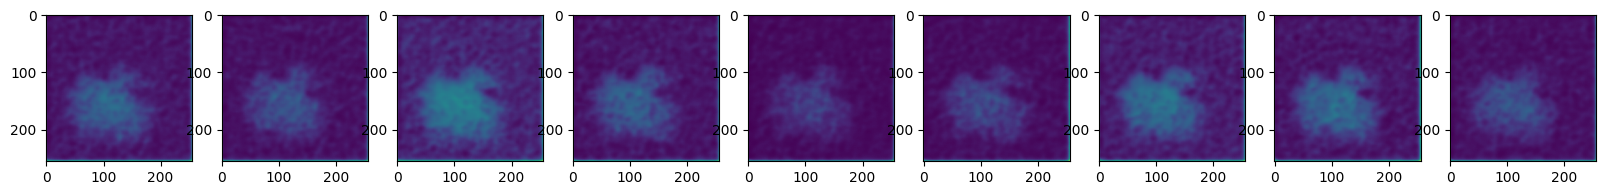

In [181]:
fig ,ax = plt.subplots(1,9, figsize = (20,10))
for i in range(9):
        ax[i].imshow(samples[i].reshape(256,256))

plt.show()

In [82]:
z = (torch.randn((20,32))).to(device)[0].reshape(1,32)
samples = []
for i in range(19):
    with torch.no_grad():
        decoded = model.decode(z)
        samples.append(decoded.cpu().detach().numpy())
        mu, logvar = model.encode(decoded)
        z = model.reparameterize(mu, logvar)



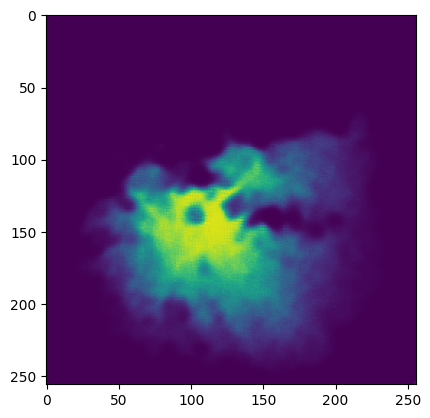

In [79]:
plt.imshow(samples[-1].reshape(256,256))

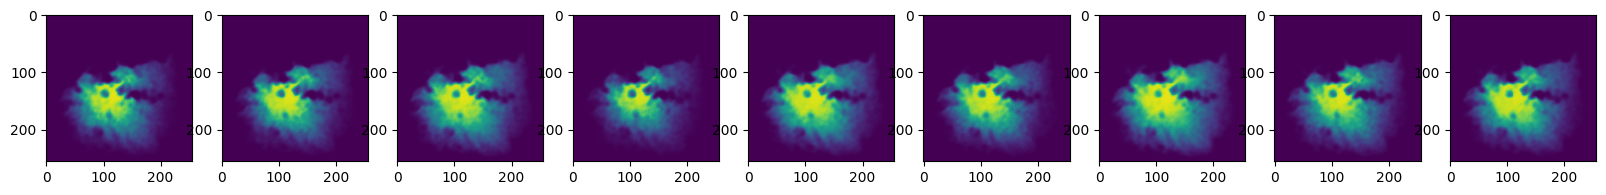

In [80]:
fig ,ax = plt.subplots(1,9, figsize = (20,10))
for i in range(9):
        ax[i].imshow(samples[i].reshape(256,256))

plt.show()

In [76]:
torch.save(model, "model.pth")

Latent dimension: 32
Shape of generated images: (19, 1, 256, 256)


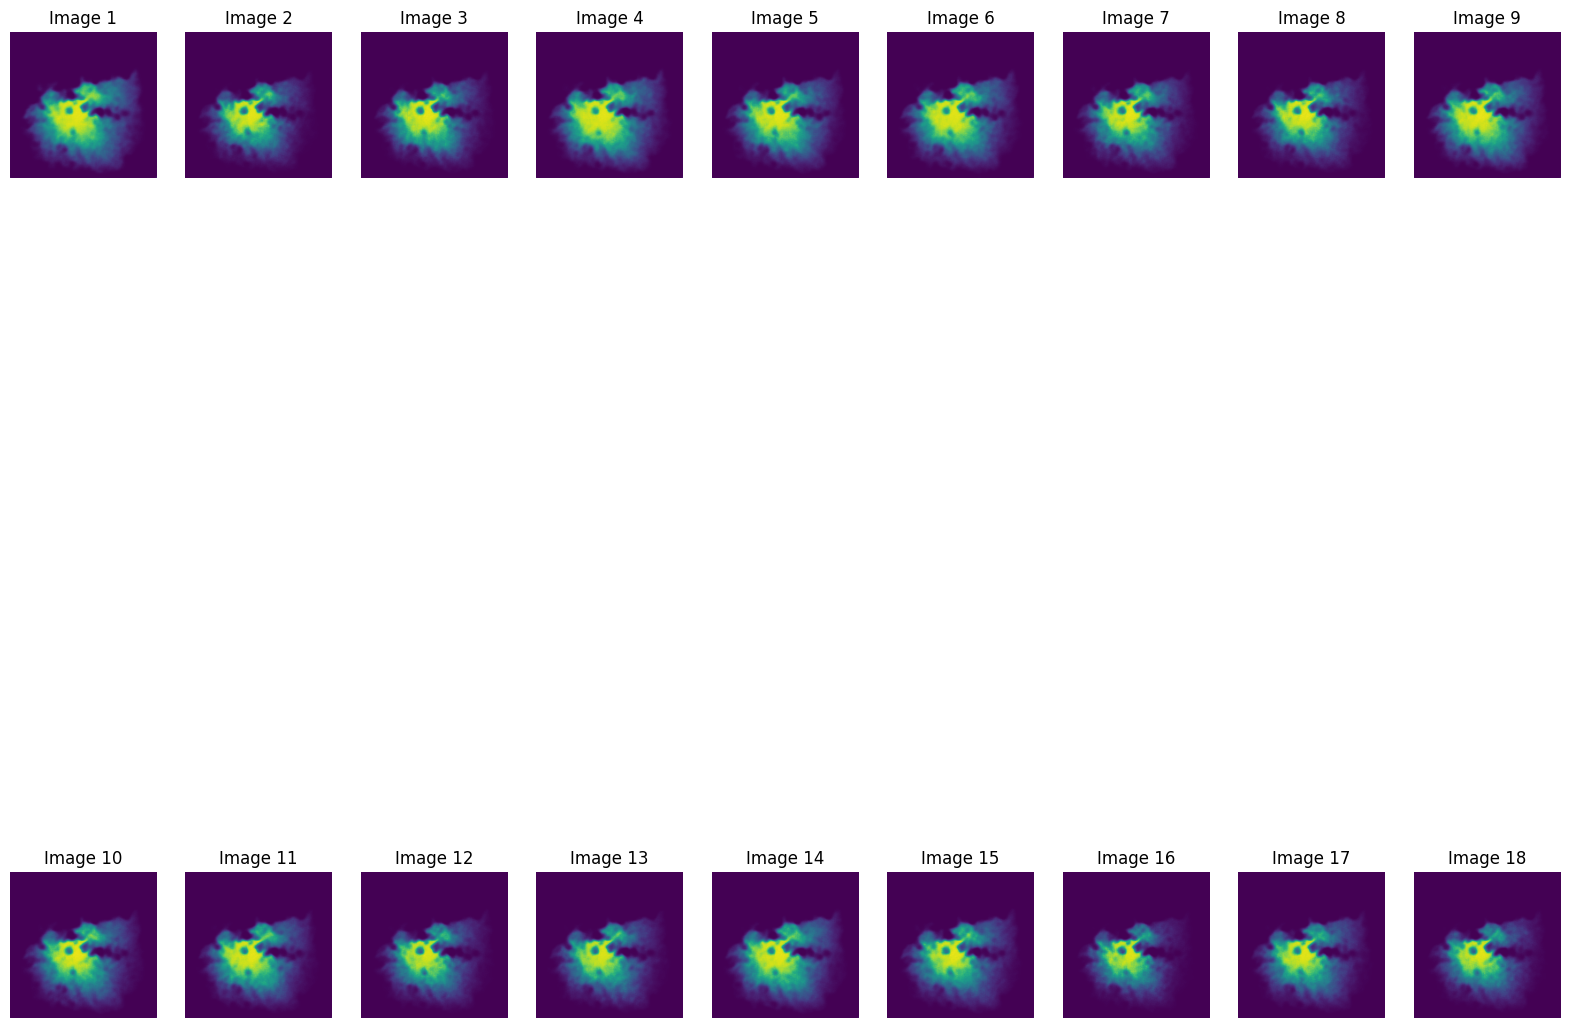

In [87]:
num_images = 19

# Sample latent vectors z from the standard normal distribution
latent_dim =32# Ensure this matches the latent dimension of your model
print(f"Latent dimension: {latent_dim}")
z = torch.randn(num_images, latent_dim).to(device)

# Generate images from the latent vectors
with torch.no_grad():
    generated_images = model.decode(z).cpu().numpy()

print(f"Shape of generated images: {generated_images.shape}")

# threshold_low = 0.3
# threshold_high = 0.5
# generated_images[generated_images < threshold_low] = 0
# generated_images[generated_images > threshold_high] = 1

# Reshape the generated images to their original dimensions
generated_images = generated_images.reshape(num_images, 256, 256)  # Adjust to your image dimensions

# Plot the 100 generated images
fig, axes = plt.subplots(2, 9, figsize=(20, 20))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(generated_images[i])
    ax.axis('off')
    ax.set_title(f'Image {i + 1}')

In [ ]:
###TDL
### change size back to normal
### test whether it changes
### try different architecture
### change loss